# LSTMs for generation

In this notebook I will present and describe some LSTM based text generation models. I have trained them and generated text using them locally, training these models too extensively was a bit too slow. I just investigated their behavior while training, this in terms of loss evolution and quality of the generated text. 

They are not adapted to allow for training on a more advanced system. Also the way data is used would probably get an upgrade when trained on specialized systems. Also the tokenizer would probably be something else. And the models would probably have evolved more too.

But overall I am happy to have gained some insight in the usage of LSTMs.


In [1]:
%pip install torch
%pip install PathLib
%pip install nltk
%pip install wakepy
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor
import torch.nn.functional as F

In [2]:
import pickle
import re
from collections import Counter
import nltk
import numpy as np
import torch
import pathlib

In [3]:
DATADIR = 'data'
DATA_RELATED_DIR = 'data_related'
TRAINED_MODELS_DIR = 'trained_models'
HP_TEXT_DIR = pathlib.Path(DATADIR).joinpath('harry_potter_text')
dirs=[DATA_RELATED_DIR, TRAINED_MODELS_DIR]
for dir in dirs:
    pathlib.Path(dir).mkdir(parents=True, exist_ok=True)

In [5]:
"""def generate_vocabulary(individual_words, include_special_tokens=False):
    condition_keys = sorted(individual_words)
    print(conditions.unique())
    result = dict(zip(condition_keys, range(len(condition_keys))))
    print(len(result))
    return result
"""

'def generate_vocabulary(individual_words, include_special_tokens=False):\n    condition_keys = sorted(individual_words)\n    print(conditions.unique())\n    result = dict(zip(condition_keys, range(len(condition_keys))))\n    print(len(result))\n    return result\n'

In [58]:
def generate_vocabulary(individual_words, min_threshold, include_special_tokens=False):
    """
    Return {token: index} for all train tokens (words) that occur min_threshold times or more,
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    """
    #create a list of words that happen min_threshold times or more in that string
    condition_keys = sorted([key for key, value in Counter(individual_words).items() if value >= min_threshold])
    #generate the vocabulary(dictionary)


    if not include_special_tokens:
        result = dict(zip(condition_keys, range(len(condition_keys))))
        return result
    else:
        result = dict(zip(condition_keys, range(3,len(condition_keys)+3)))
        orig = {"BOS": 0, "EOS": 1, "UNK": 2}
        orig.update(result)
        return orig

### Get text

This piece of code takes all text files in a directory, and does some cleaning, substitutes 'weird' characters using a regular expression. And finally it returns and saves the cleaned text. If cleaned text is already created it opens the file, and deserializes the it. 

In [59]:
def get_hp_text():
    text_files = pathlib.Path(HP_TEXT_DIR).iterdir()
    path_to_hp_text = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_text.pkl")

    filepath = pathlib.Path(DATA_RELATED_DIR, "harry_potter_text.pkl")

    if not path_to_hp_text.exists():
        all_text = ""
        for book in text_files:
             path_to_book = pathlib(HP_TEXT_DIR).joinpath(HP_TEXT_DIR, book)

             with open(path_to_book, "r", encoding="utf8") as f:
                text = f.readlines()

             text = [line for line in text if "Page" not in line]
             text = " ".join(text).replace("\n", "")
             text = [word for word in text.split(" ") if len(word) > 0]

             text = " ".join(text)
             text = re.sub("[^a-zA-Z0-9-_*.!,? \"\']", "", text)
             all_text+=text

        with open(path_to_hp_text, 'wb') as handle:
            pickle.dump(all_text, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_hp_text, 'rb') as handle:
            all_text = pickle.load(handle)

    return all_text

### Get tokens

The cleaned text returned from the previous function is used to create tokenids. As I am not that specialized in language models, I have used some tokenizer, not knowing whether it is the best option. I am just happy to get some tokens. The tokens are serialized and saved, for later reuse.

In [60]:
def get_tokens():
    path_to_tokens = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_tokens.pkl")
    if not path_to_tokens.exists():
        tokens=nltk.word_tokenize(get_hp_text())
        with open(path_to_tokens, 'wb') as handle:
            pickle.dump(tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_tokens, 'rb') as handle:
            tokens = pickle.load(handle)
    return tokens

### Vocabularies

The tokens are used to generate two complementary vocabularies.

In [61]:
def get_2_vocabs():
    path_to_vocab= pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_vocab.pkl")
    path_to_inv_vocab = pathlib.Path(DATA_RELATED_DIR).joinpath("harry_potter_inv_vocab.pkl")
    tokens= get_tokens()
    if not path_to_vocab.exists():
        vocab=generate_vocabulary(tokens, 1)
        inv_vocab = {v: k for k, v in vocab.items()}

        with open(path_to_vocab, 'wb') as handle:
            pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(path_to_inv_vocab, 'wb') as handle:
            pickle.dump(inv_vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(path_to_vocab, 'rb') as handle:
             vocab= pickle.load(handle)
        with open(path_to_inv_vocab, 'rb') as handle:
             inv_vocab= pickle.load(handle)

    return vocab, inv_vocab

In [62]:
class DataBuilderMemmap:
    def __init__(self, path_to_memmap, shape_of_memmap,seq_len,  word2idx={}, idx2word={}):
        self.seq_len = seq_len
        self.number_of_tokens = shape_of_memmap[0]
        self.word2idx=word2idx
        self.idx2word=idx2word
        self.path_to_memmap = path_to_memmap
        self.shape_of_memmap = shape_of_memmap
        self.tokens = np.memmap(self.path_to_memmap, dtype=np.int32, mode='r', shape=self.shape_of_memmap)
    def grab_random_sample(self):
        start = np.random.randint(0, self.number_of_tokens - self.seq_len)
        end = start + self.seq_len
        text_slice = self.tokens[start:end].copy()

        input_text = torch.from_numpy(text_slice[:-1])
        label = torch.from_numpy(text_slice[1:])

        return input_text, label

    def grab_random_batch(self, batch_size):
        input_texts, labels = [], []

        for _ in range(batch_size):
            input_text, label = self.grab_random_sample()

            input_texts.append(input_text)
            labels.append(label)

        input_texts = torch.stack(input_texts)
        labels = torch.stack(labels)

        return input_texts, labels

In [65]:
def create_memmap(tokenized_text, word2idx):
    path_to_memmap = pathlib.Path().cwd().joinpath(DATA_RELATED_DIR,"hp_memmap.dat")
   
    #pathlib.Path(path_to_memmap).rename(path_to_memmap)
    #pathlib.Path(path_to_memmap).unlink(missing_ok=True)

    tt=np.asarray([word2idx[w] for w in tokenized_text], dtype=np.int32)
    f = np.memmap(path_to_memmap, dtype=np.int32, mode='w+', shape=tt.shape)
    f[:] = tt[:]

    return path_to_memmap, tt.shape, f

def get_databuildermemmap(seq_len, tokens, word2idx, idx2word):
    path_to_memmap, shape_of_memmap, f = create_memmap(tokens, word2idx)

    db=DataBuilderMemmap(path_to_memmap, shape_of_memmap,seq_len,  word2idx, idx2word)
    return db, f

### Data

The data is produced by a simple class, it produces batches of sentences and the sentences that should be produced.

So if the sentence from which to create a new token would be:

` To be or not to be, that's the `

Than the 'target' sentence could be

` be or not to be, that's the question `

The tokens parameter is a complete tokenized version of the complete text, which is sliced using random int values, while keeping some set length. This part should probably be implemented using an arraymap which is more memory efficient.


In [10]:
nltk.download('punkt_tab')
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor
import torch.nn.functional as F

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\wilfr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Simple word generation model

### Forward method

This model is a simple model to embed tokens that represent word ids. Its forward method takes in a complete sentence, produces an embedding, passes this embedding to the LSTM block which creates an output that is passed to a linear layer to produce logits, for every input. As a complete piece of text is passed to an LSTM at once, no further adaptations can be applied during training. 

### Write method

Contrary to the forward method, the write method generates one token at the time. In this way multiple types of generations are possible. Furthermore it doesn't differ that much from the forward method, it just produces one token at the time. And allows for different ways of text generation, just pick the next token that is most probable. The other option selects a token uisng probabilities, so basically even the worst fit could be chosen.


In [11]:
class LSTMForWordGeneration(nn.Module):
    def __init__(self, word2idx, idx2word,embedding_dim=128, hidden_size=256, n_layers=3):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, self.num_words)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.embedding(x)
        output, (h, c) = self.lstm(x)
        logits = self.fc(output)
        return logits

    def write(self, text, max_words, greedy=False):

        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = torch.zeros(self.n_layers, self.hidden_size)
        cell = torch.zeros(self.n_layers, self.hidden_size)

        for i in range(max_words):

            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            out, (hidden, cell) = self.lstm(x, (hidden, cell))

            out = self.fc(out)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)

        return gen_string

### Training

The loss function is cross entropy loss. The optimizer is AdamW. AdamW is an optimization algorithm, developed as a modification to the Adam optimizer to decouple weight decay from gradient-based updates. This decoupling was introduced to address overfitting issues that often arise when using standard Adam, especially for large-scale neural network models.

The training function produces iterational data like loss, text produced, model name. The configuration file is saved too, for investigation afterwwards.

In [ ]:
from pathlib import Path
import pandas as pd
from torch import optim, nn
import gc

def train(model, word2idx, idx2word, tokens, config, write_better=False):
    training_data = {
        "model":[],
        "iteration":[],
        "training data length":[],
        "loss": [],
        "generated text": []
    }
    texts_generated = {
        "iteration": [],
        "loss":[],
        "probabilities":[],
        "texts": [],
    }

    name=model.__class__.__name__
    new_dir = pathlib.Path(TRAINED_MODELS_DIR).joinpath(name)
    new_dir.mkdir(parents=True, exist_ok=True)

    iterations = config["iterations"]
    max_len = config["max_len"]
    evaluate_interval = config["evaluate_interval"]
    lr = config["lr"]
    batch_size = config["batch_size"]

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    np.random.seed(0)
    #dataset = DataBuilder(max_len, tokens, word2idx, idx2word)
    dataset, f = get_databuildermemmap(max_len, tokens, word2idx, idx2word)
    model.train()
    for iteration in range(iterations):

        input_texts, labels = dataset.grab_random_batch(batch_size=batch_size)
        input_texts, labels = input_texts, labels
        optimizer.zero_grad()
        output = model(input_texts)
        output = output.transpose(1,2)

        loss = loss_fn(output, labels.long())

        loss.backward()
        optimizer.step()

        if iteration % evaluate_interval == 0:
            model.eval()
            torch.no_grad()
            print("--------------------------------------")
            print(f"training data length {max_len}")
            print(f"Iteration {iteration}")
            print(f"Loss {loss.item()}")
            generated_text = model.write(["Spells"], max_words=50)
            print(generated_text)
            if write_better:
                generated_texts, probabilities = model.write_better(["Spells"],max_words=50, k=3)
                print("Sample Generation")
                for text, probability in zip(generated_texts, probabilities):
                    print(f"text: {text} probability: {probability}")
            print("--------------------------------------")
            training_data["model"].append(name)
            training_data["iteration"].append(iteration)
            training_data["training data length"].append(max_len)
            training_data["loss"].append(loss.item())
            training_data["generated text"].append(generated_text)

            if write_better:
                texts_generated["iteration"].append(iteration)
                texts_generated["loss"].append(loss.item())
                texts_generated["probabilities"].append(probabilities)
                texts_generated["texts"].append(generated_texts)

            torch.enable_grad()
            model.train()
    td=pd.DataFrame(training_data)
    td.set_index(["model", "iteration"])
    td.to_csv(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,"training_data.csv"), encoding="utf8")
    cd=pd.DataFrame(list(config.items()), columns=["key", "value"])

    cd.to_csv(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,"config_data.csv"), encoding="utf8", index=False)

    if write_better:
        with open(pathlib.Path(TRAINED_MODELS_DIR).joinpath(name,'generated_texts.pkl'), 'wb') as fh:
            pickle.dump(texts_generated, fh, protocol=pickle.HIGHEST_PROTOCOL)

    torch.save(model.state_dict(), pathlib.Path(TRAINED_MODELS_DIR).joinpath(name+"/model_state.pth"))
    del dataset
    del f
    gc.collect()

### Configuration

To setup the model and some training parameters. I use some configuration dictionary.

In [13]:
def get_config():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=False
    return config

### Getting data

Get the data and related constructs.

In [44]:
text = get_hp_text()
tokens = get_tokens()
word2idx, idx2word = get_2_vocabs()

### Start training

In [66]:
from wakepy import keep 
config=get_config()
model = LSTMForWordGeneration(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=False)


c:\Users\wilfr\code-projects\lstms-for-generation\data_related\hpmemmap.dat
(90067,)
--------------------------------------
training data length 20
Iteration 0
Loss 8.844343185424805
Spells mistaken kitchen stutter NICHOLAS railway face baking rot himself dropping going fastest Taped uneasy dust long Excuses haircut legs ice-cold killers silent oughta Isle buckled movements kill Prophet Young granite loyalties notes happening basking free Want supposed referees dinner Scowling froze toil meet While Counter-curses towered wore dried Wriggling listening
--------------------------------------
--------------------------------------
training data length 20
Iteration 30
Loss 6.675443649291992
Spells P-P-Potter close really So long I this know the followers ! and , at Harry year and holding backed nearly even it wait Hes a of don us kept at without game on Hall to its the him is . up seemed seem and you there best George the on
--------------------------------------
--------------------------

## Attention

To get an idea of what attention means mathematically let's compare some matrix multiplications. To get an idea of what attention means mathematically let's compare some matrix multiplications. These calculations are a means of expressing the mechanisms behind attention. Most of the time q(uery) and k(ey) matrices will contain much more complexity than expressed by the matrix multiplications below.

### Some direct multiplications

Firstly, a relatively straight matrix multiplication of three matrices. In this case the third element of the q(uery) matrix is a 1, all the rest are zeroes. Matrix multiplying q with the one hot encoded k(eys) selects the third row of this k(eys) matrix. As a consequence the adapted k(eys) matrix selects the third v(alues) row.

In [ ]:
q = F.one_hot(torch.tensor([2]), 5)
k = F.one_hot(torch.arange(5), 5)
v = torch.randint(2, 8, (5,2 ))
print("q")
print(q)
print("k")
print(k)
print("v")
print(v)

q_times_k=torch.mm(q,k.T)
print("q_times_k")
print(q_times_k)
print("q_times_k_times_v")
print(torch.mm(q_times_k, v))

q
tensor([[0, 0, 1, 0, 0]])
k
tensor([[1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]])
v
tensor([[5, 2],
        [2, 4],
        [4, 5],
        [5, 4],
        [7, 2]])
q_times_k
tensor([[0, 0, 1, 0, 0]])
q_times_k_times_v
tensor([[4, 5]])


### Some softer multiplications

In this case the q(uery) isn't as decisive as before, the q matrix is softer. In a numeric world the softer values are responsible for some weighted v(alues) matrix. As the keys stay the same, every value in the v(alues) matrix counts except the first, as the first value in the q(ueriy) matrix is zero. The other v(alues) are weighted.

In [19]:
q= torch.FloatTensor([0,0.3,0.2,0.4,0.1]).unsqueeze(0)
k = F.one_hot(torch.arange(5), 5).to(torch.float)
v = v.to(torch.float)

print("q")
print(q)
print("k")
print(k)
print("v")
print(v)

q_times_k=torch.mm(q,k.T)
print("q_times_k")
print(q_times_k)
print("q_times_k_times_v")
print(torch.mm(q_times_k, v))

q
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
k
tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])
v
tensor([[5., 2.],
        [2., 4.],
        [4., 5.],
        [5., 4.],
        [7., 2.]])
q_times_k
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
q_times_k_times_v
tensor([[4.1000, 4.0000]])


### Softer keys

As the keys of matrices in deep learning most of the times aren't that explicitly defined, I have adjusted these too, slightly, to see some effect. I have adjusted the keys for the second v(alues) row. As a result these values changed, from [2,5] to [2.5,4.0]. This change has its effect on the final result of the complete matrix multiplication. 

In [20]:
q= torch.FloatTensor([0,0.3,0.2,0.4,0.1]).unsqueeze(0)
k = F.one_hot(torch.arange(5), 5).to(torch.float)
k[1,1]=0.5
k[2,1]=0.5
v = v.to(torch.float)

print("q")
print(q)
print("k")
print(k)
print("v")
print(v)

k_times_v = torch.mm(k.T, v)
print("k_times_data")
print(k_times_v)

q_times_k_times_v=torch.mm(q,k_times_v)
print("q_times_k_times_v")
print(q_times_k_times_v)


q
tensor([[0.0000, 0.3000, 0.2000, 0.4000, 0.1000]])
k
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
v
tensor([[5., 2.],
        [2., 4.],
        [4., 5.],
        [5., 4.],
        [7., 2.]])
k_times_data
tensor([[5.0000, 2.0000],
        [3.0000, 4.5000],
        [4.0000, 5.0000],
        [5.0000, 4.0000],
        [7.0000, 2.0000]])
q_times_k_times_v
tensor([[4.4000, 4.1500]])


### The attention usage

In this case attention is used to adjust word/token embeddings to express semantical or syntactical relations between different parts of a sentence. As I only use Attention once, it can only convey the information it is capable of conveying, as a sentence can be composed of multiple semantical and syntactical twists this is probably too limited for the texts it is trained on. It should provide better results than a model without attention.

A difference that can be observed in the Attention class definition is the bmm operation, it is a batched version of the matrix multiplication. There exists an existing MultiHeadAttention module in torch, but I found it easier to use a custom class. But from what I know, the MultiheadAttention class can be used to implement the behavior implemented by this custom Attention class. For every timestep, a different query and value vector will be entered (the value vector is used for the key vector too). In the end diff

In [67]:
class Attention(nn.Module):
    def __init__(self, d_in,d_out, n_layers, n_directions=2):
        super().__init__()
        self.d_in=d_in
        self.d_out=d_out
        self.n_layers =n_layers
        self.n_directions=n_directions
        self.Q=nn.Linear(self.n_directions*self.n_layers*d_in,d_out)
        self.K=nn.Linear(d_in,d_out)
        self.V=nn.Linear(d_in,d_out)
    def forward(self,q ,x):
        queries=self.Q(q)
        keys = self.K(x)
        values = self.V(x)
        scores = torch.bmm(queries, keys.transpose(1,2))
        #print(queries.shape)
        #print(keys.transpose(1,2).shape)
        scores = scores/ (self.d_out**0.5)
        attention = F.softmax(scores,dim=2)
        hidden_states= torch.bmm(attention,values)
        return hidden_states

### The model with attention

As it is not desirable to apply attention to an LSTM block beign used to generate hidden and cell values while it is generating these values. A secondary LSTM block is used to absorb the results of applying attention to the values produced by the first LSTM block.

### The write_better method

The write_better method is a beam search implementation. It should generate text better as it considers the probability of a sentence as a whole, in stead of generating a word based on the highest probable word at a particular timestep. In fact, to lower computational complexity, only a k number of possibilities are considered for every timestep. As I have tried to adapt the hidden an cell values based on the highest 4 possible next words generated, the method looks and is quiet complex to capture and interpret. As a matter of fact, it is a bit hard to evaluate its correctness/soundness without a properly trained model. My current system is not able to train a model having more than 2 layers and a hidden dimension of 256 within a decent timespan. That's why I have always kept the simpler write method as a safehaven.


In [18]:
class LSTMForWordGenerationWithAttention(nn.Module):
    def __init__(self, word2idx, idx2word, embedding_dim=128, hidden_size=256, bidirectional=False, n_layers=3):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.attention = Attention(self.embedding_dim, self.n_layers * self.num_directions * self.embedding_dim, self.n_layers, self.num_directions)

        self.lstm2 = nn.LSTM(input_size=self.n_layers * self.num_directions * self.embedding_dim,
                             hidden_size=self.n_layers * self.num_directions * self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=False)

        self.fc = nn.Linear(self.n_layers * self.num_directions * self.hidden_size, self.num_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        output_enc_dec = FloatTensor()
        for i in range(x.shape[1]):
            x_i = self.embedding(x[:, i])
            x_i = x_i.unsqueeze(1)

            if i == 0:
                out, (hidden, cell) = self.lstm(x_i)
            else:
                out, (hidden, cell) = self.lstm(x_i, (hidden, cell))

            hidden = hidden.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)
            cell = cell.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)

            attention_output = self.attention(out, x_i)

            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden, cell))

            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)

            hidden = hidden.reshape(self.n_layers * self.num_directions, batch_size, -1)
            cell = cell.reshape(self.n_layers * self.num_directions, batch_size, -1)

            output_enc_dec = torch.cat([output_enc_dec, out_lstm2.unsqueeze(1)], dim=1)

        output_enc_dec = output_enc_dec.squeeze(2)
        logits = self.fc(output_enc_dec)
        return logits

    def write(self, text, max_words, greedy=False):
        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = Tensor()
        cell = Tensor()
        for i in range(max_words):
            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            x = x.unsqueeze(0)

            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, 1, -1)
            cell1 = cell.detach().clone().reshape(1, 1, -1)

            attention_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden1, cell1))

            out = self.fc(out_lstm2)
            out = out.squeeze(0)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)
        return gen_string
    
    def write_better(self, text, max_words, k=1):
        idx = torch.tensor([self.word2idx[w] for w in text])
        k_times_idx = idx.repeat(1, k).unsqueeze(2).squeeze(0)
        hidden = Tensor()
        cell = Tensor()
        k_times_probs = Tensor([0]).repeat(k)

        for i in range(max_words):
            # print("i: ",i)
            if i == 0:
                selected_idx = k_times_idx
            else:
                selected_idx = k_times_idx[:, -1].unsqueeze(1)

            x = self.embedding(selected_idx)
            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, k, -1)
            cell1 = cell.detach().clone().reshape(1, k, -1)
            # apply attention
            weighted_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(weighted_output, (hidden1, cell1))
            #print("out lstm2")
            #print(out_lstm2.shape)
            out_lstm2 = out_lstm2.permute(1, 0, 2)
            out = self.fc(out_lstm2)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            probs_top, i = torch.topk(probs.detach().flatten(), k=k, dim=-1, sorted=False)
            i = i.detach()
            indexes = np.array(np.unravel_index(i.numpy(), probs.shape)).T
            idx_next = torch.from_numpy(indexes[:, 2]).unsqueeze(1)
            k_times_idx = torch.cat([k_times_idx, idx_next], dim=1)
            k_times_probs = k_times_probs.add(torch.log10(probs_top))

            indices = torch.tensor(indexes[:, 1])
            hidden = torch.index_select(hidden, 1, indices)
            cell = torch.index_select(cell, 1, indices)

            h = h.reshape(self.n_layers * self.num_directions, k, -1)
            c = c.reshape(self.n_layers * self.num_directions, k, -1)
            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)
            # print("hidden, cell end loop")
            # print(hidden.shape)

        gen_strings = []
        for i, idxs in enumerate(k_times_idx.numpy()):
            gen_string = [self.idx2word[int(w)] for w in idxs]
            gen_strings.append(" ".join(gen_string))
        probs=torch.exp(k_times_probs)
        #print(k_times_probs)
        return gen_strings, probs


In [19]:
def get_config_attention():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=True
    return config


In [ ]:
from wakepy import keep 
config=get_config_attention()
model = LSTMForWordGenerationWithAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"], bidirectional=config["bidirectional"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=True)


c:\Users\wilfr\code-projects\lstms-for-generation\data_related\hpmemmap.dat
(90067,)
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64, 1, 512])
torch.Size([64, 512, 1])
torch.Size([64,

In [20]:
def get_config_mh_attention():
    config={}
    config["iterations"]=300
    config["max_len"]=20
    config["evaluate_interval"]=30
    config["embedding_dim"]=128
    config["hidden_size"]=256
    config["n_layers"]=2
    config["lr"]=0.003
    config["batch_size"]=64
    config["bidirectional"]=True
    config["n_heads"]=2
    return config

In [21]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in,d_out, n_layers, n_directions ,num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [Attention(d_in,d_out, n_layers, n_directions) for _ in range(num_heads)]
        )

    def forward(self,q, x):
        return torch.cat([head(q,x) for head in self.heads], dim=-1)

In [68]:
import numpy as np
import torch
from torch import nn, Tensor, FloatTensor


class LSTMForWordGenerationWithMHAttention(nn.Module):
    def __init__(self, word2idx, idx2word, embedding_dim=128, hidden_size=256, bidirectional=False, n_layers=3, n_heads=2):
        super().__init__()
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.embedding_dim = embedding_dim
        self.num_words = len(word2idx)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.num_directions = 2 if bidirectional else 1

        self.embedding = nn.Embedding(self.num_words, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=n_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.attention = MultiHeadAttentionWrapper(self.embedding_dim, self.n_layers * self.num_directions * self.embedding_dim, self.n_layers, self.num_directions,self.n_heads)

        self.lstm2 = nn.LSTM(input_size=self.n_heads*self.n_layers * self.num_directions * self.embedding_dim,
                             hidden_size=self.n_layers * self.num_directions * self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=False)

        self.fc = nn.Linear(self.n_layers * self.num_directions * self.hidden_size, self.num_words)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        output_enc_dec = FloatTensor()
        for i in range(x.shape[1]):
            x_i = self.embedding(x[:, i])
            x_i = x_i.unsqueeze(1)

            if i == 0:
                out, (hidden, cell) = self.lstm(x_i)
            else:
                out, (hidden, cell) = self.lstm(x_i, (hidden, cell))

            hidden = hidden.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)
            cell = cell.reshape(1, -1, self.n_layers * self.num_directions * self.hidden_size)


            attention_output = self.attention(out, x_i)

            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden, cell))

            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)

            hidden = hidden.reshape(self.n_layers * self.num_directions, batch_size, -1)
            cell = cell.reshape(self.n_layers * self.num_directions, batch_size, -1)

            output_enc_dec = torch.cat([output_enc_dec, out_lstm2.unsqueeze(1)], dim=1)

        output_enc_dec = output_enc_dec.squeeze(2)
        logits = self.fc(output_enc_dec)
        return logits

    def write(self, text, max_words, greedy=False):
        idx = torch.tensor([self.word2idx[w] for w in text])
        hidden = Tensor()
        cell = Tensor()
        for i in range(max_words):
            if i == 0:
                selected_idx = idx
            else:
                selected_idx = idx[-1].unsqueeze(0)

            x = self.embedding(selected_idx)
            x = x.unsqueeze(0)

            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, 1, -1)
            cell1 = cell.detach().clone().reshape(1, 1, -1)

            attention_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(attention_output, (hidden1, cell1))

            out = self.fc(out_lstm2)
            out = out.squeeze(0)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            if greedy:
                idx_next = torch.argmax(probs).squeeze(0)
            else:
                idx_next = torch.multinomial(probs, num_samples=1).squeeze(0)

            idx = torch.cat([idx, idx_next])

        gen_string = [self.idx2word[int(w)] for w in idx]
        gen_string = " ".join(gen_string)
        return gen_string

    def write_better(self, text, max_words, k=1):
        idx = torch.tensor([self.word2idx[w] for w in text])
        k_times_idx = idx.repeat(1, k).unsqueeze(2).squeeze(0)
        hidden = Tensor()
        cell = Tensor()
        k_times_probs = Tensor([0]).repeat(k)

        for i in range(max_words):
            # print("i: ",i)
            if i == 0:
                selected_idx = k_times_idx
            else:
                selected_idx = k_times_idx[:, -1].unsqueeze(1)

            x = self.embedding(selected_idx)
            if i == 0:
                out, (hidden, cell) = self.lstm(x)
            else:
                out, (hidden, cell) = self.lstm(x, (hidden, cell))

            hidden1 = hidden.detach().clone().reshape(1, k, -1)
            cell1 = cell.detach().clone().reshape(1, k, -1)
            # apply attention
            weighted_output = self.attention(out, x)
            out_lstm2, (h, c) = self.lstm2(weighted_output, (hidden1, cell1))
            #print("out lstm2")
            #print(out_lstm2.shape)
            out_lstm2 = out_lstm2.permute(1, 0, 2)
            out = self.fc(out_lstm2)

            if len(out) > 1:
                out = out[-1, :].unsqueeze(0)

            probs = self.softmax(out)

            probs_top, i = torch.topk(probs.detach().flatten(), k=k, dim=-1, sorted=False)
            i = i.detach()
            indexes = np.array(np.unravel_index(i.numpy(), probs.shape)).T
            idx_next = torch.from_numpy(indexes[:, 2]).unsqueeze(1)
            k_times_idx = torch.cat([k_times_idx, idx_next], dim=1)
            k_times_probs = k_times_probs.add(torch.log10(probs_top))

            indices = torch.tensor(indexes[:, 1])
            hidden = torch.index_select(hidden, 1, indices)
            cell = torch.index_select(cell, 1, indices)

            h = h.reshape(self.n_layers * self.num_directions, k, -1)
            c = c.reshape(self.n_layers * self.num_directions, k, -1)
            hidden = torch.div(torch.add(hidden, h), 2, rounding_mode=None)
            cell = torch.div(torch.add(cell, c), 2, rounding_mode=None)
            # print("hidden, cell end loop")
            # print(hidden.shape)

        gen_strings = []
        for i, idxs in enumerate(k_times_idx.numpy()):
            gen_string = [self.idx2word[int(w)] for w in idxs]
            gen_strings.append(" ".join(gen_string))
        probs=torch.exp(k_times_probs)
        #print(k_times_probs)
        return gen_strings, probs

In [ ]:
from wakepy import keep 
config=get_config_mh_attention()
model = LSTMForWordGenerationWithMHAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                      hidden_size=config["hidden_size"], n_layers=config["n_layers"], bidirectional=config["bidirectional"], n_heads=config["n_heads"])
with keep.running():
    train(model, word2idx, idx2word, tokens, config, write_better=True)

## Generate data while training

In the directory named "trained_models_" I have created some data for 3 previously presented models in their respective directories, I have set the models configurable parameters as in the config_data.csv files. The trained model's parameters are in "model_state.pth". "training_data.csv" contains loss, number of iterations, text generated after every 1000 of iterations using the "write" method for the respective model.



### Generate Loss plots

To compare losses for the 3 models, the loss data is plotted.

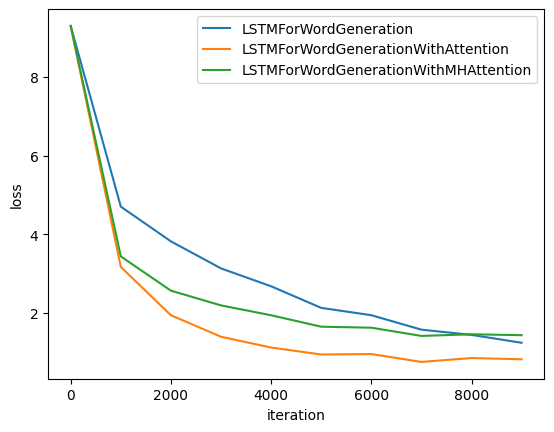

In [15]:
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd

path = Path(TRAINED_MODELS_DIR+"_")    
models = list(path.iterdir())
for model_path in models:
    cd=pathlib.Path(model_path).joinpath("training_data.csv")
    td=pd.read_csv(cd)
    plt.plot(td.iteration, td.loss, label=model_path.name)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
plotpath=pathlib.Path("plots_and_outputs")
plotpath.mkdir(parents=True, exist_ok=True)
losspath=plotpath.joinpath("loss.png")
plt.savefig(losspath.resolve())

### Text generated by the model's write method

To get an overview of every piece of text generated after every 1000 training iterations. I have put the texts in a single file per model. The text just contains 50 tokens, no beginning of sentence tokens, end of sentence tokens, unknown tokens. Ive is a token for I've, just like were is a token for we're, and more shortcuts. As the focus of this project is not to find the best tokenizer, but to find out whether I am able to adapt a model to generate more well formed texts, I don't want to find a better/other tokenizer.

In [23]:
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
import pandas as pd

path = Path(TRAINED_MODELS_DIR+"_")    
models = list(path.iterdir())
plotpath=pathlib.Path("plots_and_outputs")
plotpath.mkdir(parents=True, exist_ok=True)
for model_path in models:
    cd=pathlib.Path(model_path).joinpath("training_data.csv")
    td=pd.read_csv(cd)
    textpath=plotpath.joinpath(model_path.name+"/generated_text"+".txt")
    textpath.parent.mkdir(parents=True, exist_ok=True)
    print(str(textpath.resolve()))
    length=len(td["generated text"])
    with open(str(textpath.resolve()), "w") as f:
        for i,line in enumerate(td["generated text"]):
            if i<length-1:
                f.write(line + "\n")
            else:
                f.write(line)

            
        



C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGeneration\generated_text.txt
C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGenerationWithAttention\generated_text.txt
C:\Users\wilfr\code-projects\lstms-for-generation\plots_and_outputs\LSTMForWordGenerationWithMHAttention\generated_text.txt


In [28]:
%pip install torchview

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)

   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   ---------------------------------------- 0/2 [graphviz]
   -------------------- ------------------- 1/2 [torchview]
   ---------------------------------------- 2/2 [torchview]

Note: you may need to restart the kernel to use updated packages.


### Create a visual overview of a model

As the models become complexer, it sometimes is a good idea to get an overview of a model. The image generated by the code below is a complete overview, it would of course be possible to generate partial images by selecting specific pieces of the model and generate random data with correct dimensions. I am not going to focus on visualising parts of the model any further.
[Visual overview of the model with the multiheaded attention](trained_models\LSTMForWordGenerationWithMHAttention\visual_rep.gv.png)

In [69]:
from torchview import draw_graph
import gc
config=get_config_mh_attention()
dataset, f =  get_databuildermemmap(config["max_len"], tokens, word2idx, idx2word)
input_texts, labels = dataset.grab_random_batch(batch_size=config["batch_size"])

model = LSTMForWordGenerationWithMHAttention(word2idx, idx2word, embedding_dim=config["embedding_dim"],
                                                 hidden_size=config["hidden_size"], n_layers=config["n_layers"],
                                                 bidirectional=config["bidirectional"], n_heads=config["n_heads"])

model_graph = draw_graph(model, input_texts, expand_nested=False, hide_inner_tensors=True,hide_module_functions=True, depth=1)

model_graph.visual_graph.save("trained_models/LSTMForWordGenerationWithMHAttention/visual_rep.gv")
md=model_graph.visual_graph
md.render(format="png").replace('\\', '/')
del dataset
del f
gc.collect()



(process:9284): Pango-WARNING **: 17:45:49.585: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


13129